## OBJECTIVE : 
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

## Importing Libraries & getting Data

In [1]:
import numpy as np 
import pandas as pd 
import sqlite3 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
import math 
import os 
import string 
from tqdm import tqdm 

import warnings 
warnings.filterwarnings('ignore')

# Metrics libraries
from sklearn.metrics import accuracy_score ,confusion_matrix, roc_curve, auc ,roc_auc_score

# NLP libraries 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.python.client import device_lib


In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14155547559712360626
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1753127323
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13400865995832449692
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
connection = sqlite3.connect('G:/My Drive/datasets/amazon food review/dataset/database.sqlite')

In [5]:
# ignoring datapoints where score = 3 (neutral review)

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
LIMIT 100000
""", connection)

In [6]:
# label encoding score into positive (x>3) and negative (x<3)

def partition(x):
    if x < 3:
        return 0
    else:
        return 1

score_with_neutral = filtered_data['Score']
score_wo_neutral = score_with_neutral.map(partition)

filtered_data['Score'] = score_wo_neutral

In [7]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             100000 non-null  object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 100000 non-null  object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [9]:
filtered_data.shape

(100000, 10)

In [10]:
display = pd.read_sql_query("""
SELECT UserId, ProductId ,ProfileName ,Time, Score ,Text ,COUNT(*)
FROM Reviews 
GROUP BY UserId 
HAVING COUNT(*) > 1
""", connection)

display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [11]:
display.shape

(80668, 7)

In [12]:
display['COUNT(*)'].sum()
display = pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score != 3 AND UserId='#oc-R11D9D7SHXIJB9'
ORDER BY ProductId
""", connection)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


#### NOTE : 
- It can be seen that same user has multiple reviews with same values for all the parameters.

- So, in order to get unbiased results ,we need to remove the rows having same parameters.

- Steps to do so : 
    - first sort the data according to ProductId in ascending order.
    - Then just keep the first similar product review and delete the others.


In [13]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [14]:
clean_data = sorted_data.drop_duplicates(
    subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)

clean_data.shape

(87775, 10)

## Data Preprocessing

#### Steps : 

1. Begin by removing the HTML tags

2. Remove any punctuations or limited set of special characters like , or . etc

3. Check if the word is made up of english letters and is not alpha-numeric.

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the words to lowercase

6. Remove Stopwords

7. Stemming the word 

In [15]:
# sample reviews

review_1 = clean_data['Text'].values[0]
print(review_1)
print('---------------------------------------')

review_2 = clean_data['Text'].values[1]
print(review_2)
print('---------------------------------------')

review_3 = clean_data['Text'].values[2]
print(review_3)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
---------------------------------------
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
---------------------------------------
I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attrac

### 1. Removing URLs


In [16]:
review_1 = re.sub('http\S+', "", review_1)
review_2 = re.sub('http\S+', "", review_2)
review_3 = re.sub('http\S+', "", review_3)

### 2. Removing HTML tags


In [17]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(review_1, 'lxml')
review_1 = soup.get_text()

soup = BeautifulSoup(review_2, 'lxml')
review_2 = soup.get_text()

soup = BeautifulSoup(review_3, 'lxml')
review_3 = soup.get_text()

### 3. Removing Apostrophes


In [18]:
def removing_apostrophes(text):
    # general
    text = re.sub("n\'t", " not", text)
    text = re.sub("\'re", " are", text)
    text = re.sub("\'s", " is", text)
    text = re.sub("\'d", " would", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("\'t", " not", text)
    text = re.sub("\'ve", " have", text)
    text = re.sub("\'m", " am", text)

    text = re.sub("won't", "will not", text)
    text = re.sub("can\'t", "can not", text)

    return text


# isn't gets converted to 'is not' in line 3
review_3 = removing_apostrophes(review_3)
print(review_3)

I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass... but still it did nothing to get them stuck. And then I actually saw a second fly land on it once, and I watched as it flapped it is wings frantically and within 30 secs it had unstuck itself!!!! This product was a total waste of money!


### 4. Removing Numbers / Punctuations /Special Characters


In [19]:
# removing numbers
review_1 = re.sub('\S*\d\S*', "", review_1).strip()
print(review_1)
print('-----------------------------------------')

# removing special characters
review_3 = re.sub('[^A-Za-z0-9]+', ' ', review_3)
print(review_3)


My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
-----------------------------------------
I had an infestation of fruitflies they were literally everywhere flying around me in my kitchen so I bought this product hoping to at least get rid of a few But after 2 weeks only 1 fly had stuck I was going around with a notepad and squishing the buggers myself with a success rate of 2 3 a day so clearly this product was useless I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass but still it did nothing to get them stuck And then I actually saw a second fly land on it once and I watched as it flapped it is wings frantically and within 30

### 5. Removing Stopwords

In [20]:
# removing the following words from the stop words list: 'no', 'nor', 'not'

stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
                 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
                 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
                 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
                 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                 "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                 "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                 'won', "won't", 'wouldn', "wouldn't"])

### Combining all Steps

In [21]:
preprocessed_reviews = []

for text in tqdm(clean_data['Text'].values):
    text = re.sub('http\S+', "", text)
    text = BeautifulSoup(text, 'lxml').get_text()

    text = removing_apostrophes(text)

    text = re.sub('\S*\d\S*', "", text).strip()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)

    text = ' '.join(i.lower()
                    for i in text.split() if i.lower() not in stopwords)

    preprocessed_reviews.append(text.strip())

100%|██████████| 87775/87775 [00:23<00:00, 3705.72it/s]


## Splitting into train, test & validation sets

In [22]:
X = preprocessed_reviews
y = np.array(clean_data['Score'])

# Models

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans 
from sklearn.metrics.pairwise import cosine_similarity

## TFIDF

In [24]:
tfidf = TfidfVectorizer(ngram_range=(1,1) ,min_df=10)
tfidf.fit(X)

TfidfVectorizer(min_df=10)

### 1. Getting top features

In [25]:
idf_score = tfidf.idf_ 
feature_names = tfidf.get_feature_names()

In [26]:
features_idf_score = []

for i in range(len(idf_score)):
    features_idf_score.append([idf_score[i] ,feature_names[i]])

In [27]:
features_idf_score.sort(reverse=True)
features_idf_score = features_idf_score[:3000]

for i in features_idf_score[:15]:
    print(i)

[9.98464812093896, 'yucca']
[9.98464812093896, 'yougurt']
[9.98464812093896, 'yell']
[9.98464812093896, 'yeasty']
[9.98464812093896, 'yamamotoyama']
[9.98464812093896, 'writeup']
[9.98464812093896, 'wondeful']
[9.98464812093896, 'witch']
[9.98464812093896, 'wiser']
[9.98464812093896, 'winn']
[9.98464812093896, 'wildlife']
[9.98464812093896, 'wil']
[9.98464812093896, 'wheats']
[9.98464812093896, 'werther']
[9.98464812093896, 'weber']


In [28]:
top_3000_features = []
for i in range(3000):
    top_3000_features.append(features_idf_score[i][1])

for i in top_3000_features[-15:]:
    print(i)

assurance
assessment
aspirin
approached
applying
appetizers
amp
amaretto
altitude
altho
albacore
akita
aisles
administration
actively


### 2. Calculation of Co-Occurence Matrix

In [29]:
co_occurence_matrix = np.zeros((3000 ,3000))

# taking context window = 2 
context_window = 2

In [30]:
for sentence in X:
    words = sentence.split()

    for index ,word in enumerate(words):
        if word in top_3000_features:

            for i in range(max(0 ,index-context_window) ,min(index+ context_window ,len(words))):

                if words[i] in top_3000_features and words[i]!= word:
                    co_occurence_matrix[top_3000_features.index(words[i]) ,top_3000_features.index(word)] +=1

In [31]:
print(co_occurence_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 3. Finding value of optimal value for n_components to be retained

In [32]:
n_components = [10,20,50,100,200,400,500,1000,1200,1400,1500,1700,2000]
explained_variance = []

for i in n_components: 
    tsvd = TruncatedSVD(n_components=i)
    tsvd.fit(co_occurence_matrix)

    exp_var = tsvd.explained_variance_ratio_.sum()
    explained_variance.append(exp_var)

    print('n_components = {}  --> explained_variance = {}'.format(i ,exp_var))

n_components = 10  --> explained_variance = 0.282140017165565
n_components = 20  --> explained_variance = 0.46068594682781994
n_components = 50  --> explained_variance = 0.6997049991736772
n_components = 100  --> explained_variance = 0.7900895217296915
n_components = 200  --> explained_variance = 0.846148710027578
n_components = 400  --> explained_variance = 0.9054774545288331
n_components = 500  --> explained_variance = 0.9253615366535352
n_components = 1000  --> explained_variance = 0.9803978692034699
n_components = 1200  --> explained_variance = 0.9954882453533492
n_components = 1400  --> explained_variance = 1.000000000000013
n_components = 1500  --> explained_variance = 1.0000000000000138
n_components = 1700  --> explained_variance = 1.0000000000000073
n_components = 2000  --> explained_variance = 1.0000000000000078


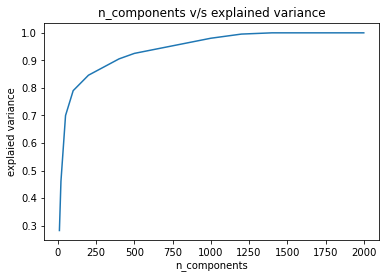

In [33]:
plt.plot(n_components ,explained_variance)

plt.xlabel('n_components')
plt.ylabel('explaied variance')
plt.title('n_components v/s explained variance')
plt.show()

#### We can clearly see that for n_components=1200 ,it covers variance of 99.54% , which is very good.

### 4. Applying KMeans Clustering

In [34]:
tsvd = TruncatedSVD(n_components=1200)
X_train = tsvd.fit_transform(co_occurence_matrix)

In [35]:
n_clusters = [x for x in range(3, 11)]
n_clusters

[3, 4, 5, 6, 7, 8, 9, 10]

In [36]:
squared_losses = []

for cluster in n_clusters:
    kmeans = KMeans(n_clusters=cluster)
    kmeans.fit(X_train)
    squared_losses.append(kmeans.inertia_)

optimal_clusters = np.argmin(squared_losses) + 2

In [37]:
print('Optimal number of clusters --> {}'.format(optimal_clusters))
print('Value of Squared-Loss for the optimal cluster --> {}'.format(min(squared_losses)))

Optimal number of clusters --> 9
Value of Squared-Loss for the optimal cluster --> 9296.444812266342


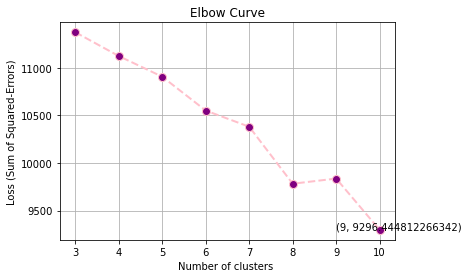

In [38]:
plt.plot(n_clusters, squared_losses, color='pink', linestyle='dashed',
         linewidth=2, marker='o', markerfacecolor='purple', markersize=8)

plt.title('Elbow Curve')
plt.grid()

plt.xlabel('Number of clusters ')
plt.ylabel('Loss (Sum of Squared-Errors)')

xy = (optimal_clusters, min(squared_losses))
plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.show()


### 5. Model Training

In [39]:
model = KMeans(n_clusters=optimal_clusters)
model.fit(X_train)

KMeans(n_clusters=9)

### 6. WordClouds

In [40]:
from wordcloud import WordCloud

def wordcloud(model, optimal_K, X):
    labels = model.labels_
    cluster_dict = {i: np.where(labels == i)[0] for i in range(optimal_K)}

    for cluster_number in range(optimal_K):
        cluster = [cluster_dict[cluster_number][i]
                   for i in range(cluster_dict[cluster_number].size)]

        reviews_cluster = []
        for i in cluster:
            reviews_cluster.append(X[i])

        review_corpus = ''
        for review in reviews_cluster:
            review_corpus = review_corpus + ' ' + review

        # wordcloud
        wordclouds = WordCloud(width=800, height=400, margin=2, scale=1, max_words=75, min_font_size=5, random_state=42,
                               background_color='black', contour_color='black', repeat=False).generate(str(review_corpus))

        plt.figure(figsize=(16, 8))
        plt.title("WordCloud for Cluster {}".format(cluster_number))
        plt.imshow(wordclouds, interpolation='bilinear')
        plt.axis('off')
        plt.show()


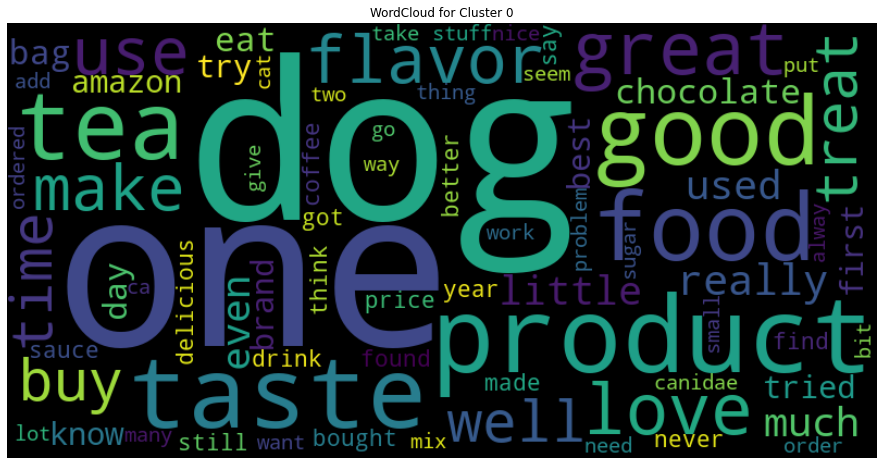

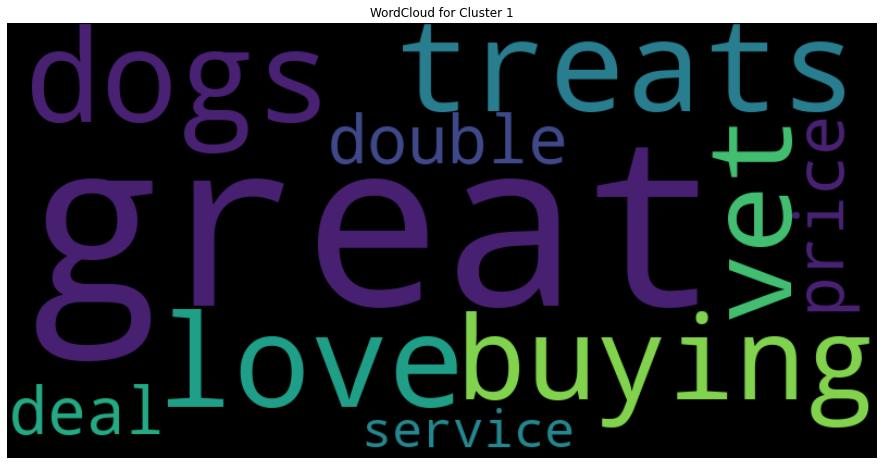

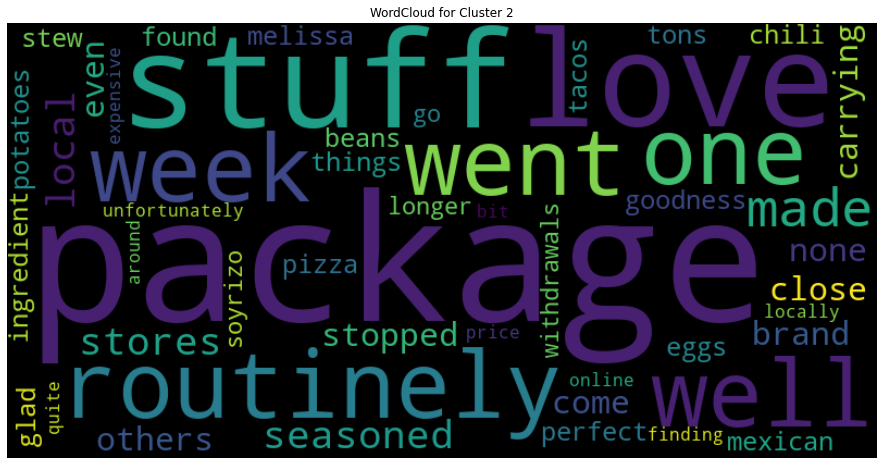

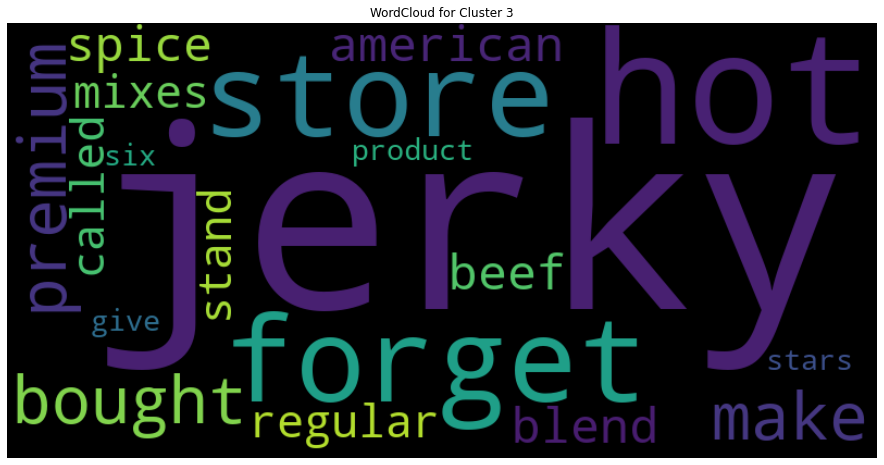

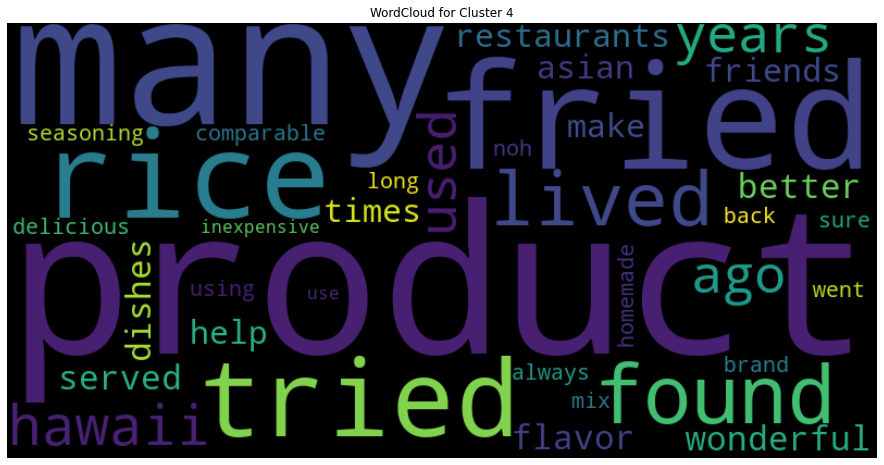

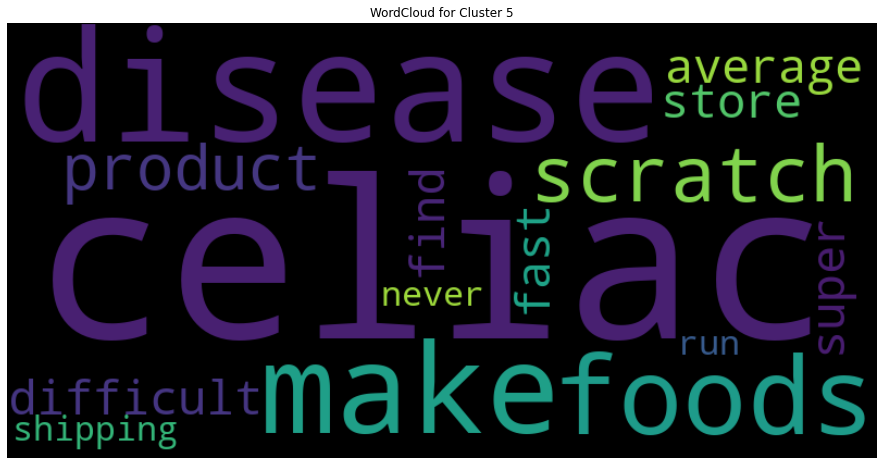

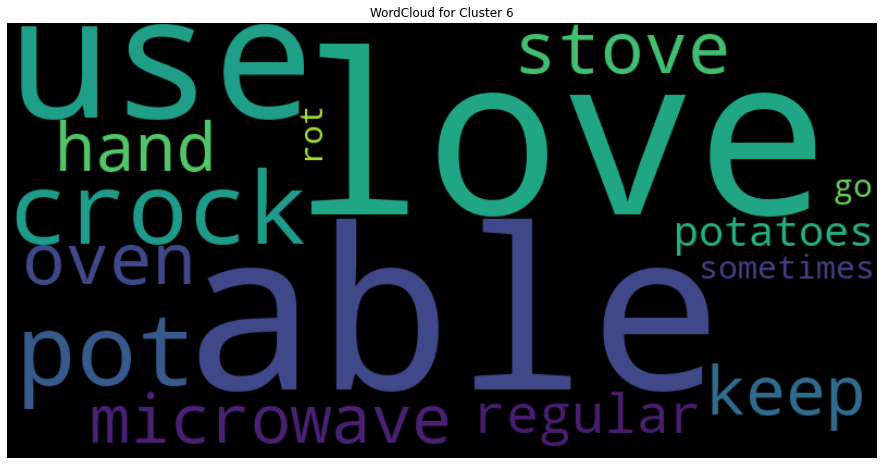

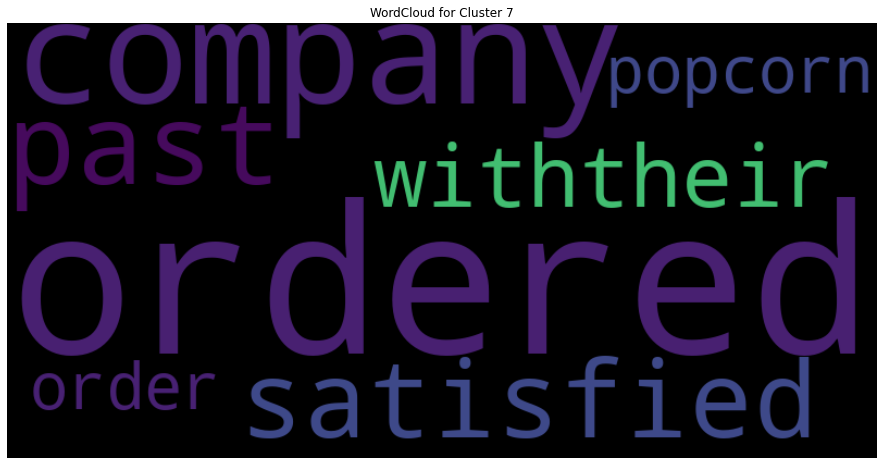

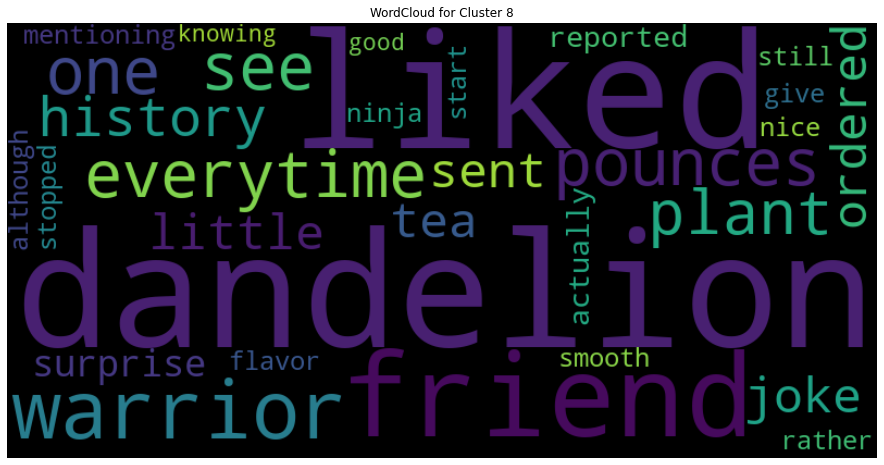

In [41]:
wordcloud(model ,optimal_clusters ,X)

### 7. Most Similar words to a given word

In [42]:
def most_similar_words(n ,word):
    top_words = []

    cosine = cosine_similarity(co_occurence_matrix)

    # similarity matrix
    value = cosine[top_3000_features.index(word)]

    # sorting index of top words similar to given word
    index = np.argsort(value)

    for i in range(n):
        top_words.append(top_3000_features[index[i]])
        
    return top_words

In [46]:
print('top 10 similar words : ')
print(most_similar_words(10 ,'swim'))

top 10 similar words : 
['yucca', 'milkbone', 'mex', 'mberry', 'marshmellows', 'marie', 'maraschino', 'manly', 'manipulate', 'makeup']
